# Chapter 2: A First Look at Tensorflow
A Tensorflow program consists of four main phases:
1. Construction of the computational graph 
2. Creating of a session
3. Running the session (perform the operations in the graph)
4. Computation for data collection and analysis 

In [12]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# define the graph within the Session() object 'sess'
with tf.Session() as sess:
    x = tf.placeholder(tf.float32, name='x')
    y = tf.placeholder(tf.float32, name='y')
    z = tf.multiply(x, y)

    # input the values 8 and 9 into the graph and then compute by running the session
    z_output = sess.run(z, feed_dict={x:8, y:9})
    print(z_output)

72.0


# What is a Tensor?
Best put in my opinion by the book "A tensor can thus be thought of as the generalization of a matrix that specifies an element with an arbitrary number of indices." (pg. 47)

In [3]:
# convert numpy arrays and python lists to tensors
import numpy as np
import tensorflow as tf

x = np.random.random(5)
y = [1, 2, 3, 4, 5]

print(type(x))
print(type(y))

<class 'numpy.ndarray'>
<class 'list'>


In [4]:
x = tf.convert_to_tensor(x, dtype=tf.float32)
y = tf.convert_to_tensor(y, dtype=tf.float32)

# these are now tensors
print(type(x))
print(type(y))

<class 'tensorflow.python.framework.ops.Tensor'>
<class 'tensorflow.python.framework.ops.Tensor'>


### Tensor shape
A tensor's __rank__ describes how many dimensions it has for example:
 - a __scalar__ is of rank 0
 - a __vector__ is of rank 1
 - a __matrix__ is of rank 2
 
### Defining a constant and variable tensor 

In [5]:
array_1d = np.array([1, 2, 3, 4, 5])
tensor_1d = tf.constant(array_1d)

array_2d = np.array([ [1, 2, 3], [4, 5, 6], [7, 8, 9] ])
tensor_2d = tf.Variable(array_2d)

with tf.Session() as sess:
    # always initialize variables before graph computation
    sess.run(tf.global_variables_initializer())
    
    # if a variable depends on the value of another variable then run:
    # var2 = tf.Variable(tensor_2d.initialized_value())
    # sess.run(tf.global_variables_initializer())
    
    print(tensor_1d.get_shape())
    print(tensor_2d.get_shape())
    print('\n')
    print(sess.run(tensor_1d))
    print(sess.run(tensor_2d))

(5,)
(3, 3)


[1 2 3 4 5]
[[1 2 3]
 [4 5 6]
 [7 8 9]]


# Data Feeds and Placeholders
You'll want to use Tensorflow's [Dataset API](https://www.tensorflow.org/guide/datasets) in serious practice. For beginning small experiments though that don't have to be efficient you can use __feeding__ through the `feed_dict` argument. This argument can be invoked in a `run()` or `eval()` function call. Here is a simple implementation of using the __feeding__ method:

In [11]:
a = 3
b = 2

x = tf.placeholder(tf.float32, shape=(a, b))
y = tf.multiply(x, 4)

# create a numpy array of random decimals for data simulation
data = np.random.rand(a, b)

# create session object and run the computation
sess = tf.Session()
print(sess.run(y, feed_dict={x:data}))

sess.close()  # must manually close the session if not using a `with` clause 

[[3.837284   3.1784267 ]
 [1.9372067  2.2520914 ]
 [0.70090336 2.4961863 ]]


# Tensorboard
Tensorboard allows you to graphically analyze your tensorflow graphs in all phases of it's development. A more comprehensive guide to this extensive and powerful tool can be found at their github page [here](https://github.com/tensorflow/tensorboard). 


### Getting started
The workflow of using Tensorboard is as follows: (pg. 58)
>1. Build your computational graph/code
>2. Attach summary ops to the nodes you are interested in examining
>3. Start running your graph as you normally would
>4. Run the summary ops 
>5. When the execution is finished, run Tensorboard to visualize the summary outputs

Step 1 has already been demonstrated thus far in the notebook.  
For step 2 you must create a summary writer pointed to the directory you'd like to save Tensorboard logs:
```python
file_writer = tf.summary.FileWriter('path/to/logs', sess.graph)
```
Steps 3 through 5 are shown in detail in the section below.  
Now ensure you have Tensorboard installed: 
```
$ which tensorboard
/usr/local/bin/tensorboard
```
Installing Tensorflow with `pip` should have done this for you already but if not you can manually install Tensorboard through `pip install tensorboard`.

You then launch Tensorboard from the terminal with:
```
$ tensorboard --logdir path/to/logs
``` 
You then open a browser and navigate to `http://localhost:6006/`.

# Linear Regression Demo: Putting it All Together
This section will demonstrate all of the beginning concepts shown so far in this notebook. In particular, this demo will optimize the linear regression model $y=W*x+b$ and analyze it using Tensorboard.

### Data creation and import

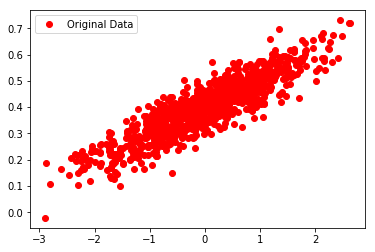

In [14]:
# create a random but nearly linear dataset following the function y=0.1 * x + 0.4z
num_points = 1000
vectors_set = []

# create a few random points
for i in range(num_points):
    W = 0.1
    b = 0.4
    x1 = np.random.normal(0.0, 1.0) # (mean, std)
    nd = np.random.normal(0.0, 0.05) 
    y1 = W * x1 + b
    
    # add impurity to the target values to prevent dataset from becoming too linear
    y1 = y1 + nd
    
    # append to dataset
    vectors_set.append([x1, y1])
    
    
# seperate the dataset
x_data = [v[0] for v in vectors_set]
y_data = [v[1] for v in vectors_set]


plt.plot(x_data, y_data, 'ro', label='Original Data')
plt.legend()
plt.show()

Having created a dataset the function  $y\_data=W*x\_data+b$  must now be optimized. The only available parameters to optimize in this case is $W$ and $b$ which was initially set as `W = 0.1` and `b = 0.4` above. Tensorflow will achieve this through these steps:
 - calculate the loss using mean squared error
 - compute the gradient 
 - update the parameters in the negative direction of the gradient function

In [36]:
# create a tensorboard scope for LinearRegression
with tf.name_scope("LinearRegression"):
    # initialize W and b to zero
    W = tf.Variable(tf.zeros([1]))
    b = tf.Variable(tf.zeros([1]))

# generate a random point for tensorflow
y = W * x_data + b

with tf.name_scope("Loss"):
    # define the mean squared error in tensorflow
    loss = tf.reduce_mean(tf.square(y - y_data))
    
# define the optimizer and assign it a loss
optimizer = tf.train.GradientDescentOptimizer(0.6) # learning rate
train = optimizer.minimize(loss)

# create the tensorboard summaries 
loss_summary = tf.summary.scalar("loss", loss)
w_summary = tf.summary.histogram("W", W)
b_summary = tf.summary.histogram("b", b)

# merge the summaries to a "board"
merged_op = tf.summary.merge_all()


# before optimizing, init all variables thus far
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

# run only after graph initialization but before training
writer = tf.summary.FileWriter('logs/')
writer.add_graph(sess.graph)

# train for 6 iterations
# the more iterations the lower loss
for i in range(6):
    summary, _ = sess.run([merged_op, train])
    writer.add_summary(summary, i)
    
    print("Epoch:", i, sess.run(W), sess.run(b), sess.run(loss))      
        
sess.close()

Epoch: 0 [0.09605686] [0.47482997] 0.008176399
Epoch: 1 [0.10500993] [0.38393322] 0.0026666787
Epoch: 2 [0.10011882] [0.40249187] 0.0024258527
Epoch: 3 [0.10147341] [0.39857292] 0.002414637
Epoch: 4 [0.10114997] [0.39941412] 0.0024141076
Epoch: 5 [0.10122319] [0.39923218] 0.0024140826


Now open a terminal and run `$ tensorboard --logdir path/to/logs/` to launch the tensorboard.

#### NOTE
Although the variables `W` and `b` are not explicitly found in the optimizer's call `optimizer.minimize(loss)` they are implicitly defined in the calculation of the loss through their use in `y`.